### Introduction

In the previous post, we implemented the upsampling and made sure it is correct
by comparing it to the implementation of the [scikit-image library](http://scikit-image.org/).
To be more specific we had _FCN-32_ _Segmentation_ network implemented which is
described in the paper _Fully convolutional networks for semantic segmentation_.

In this post we will perform a simple training: we will get a sample image from
[PASCAL VOC](http://host.robots.ox.ac.uk/pascal/VOC/) dataset along with annotation,
train our network on them and test our network on the same image. It was done this way
so that it can also be run on CPU -- it takes only 10 iterations for the training to complete.
Another point of this post is to show that segmentation that our network (FCN-32s) produces is
very coarse -- even if we run it on the same image that we were training it on. In this post
we tackle this problem by performing Conditional Random Field post-processing stage, which
refines our segmentation by taking into account pure RGB features of image and probabilities
produced by our network. Overall, we get a refined segmentation. The set-up of this post
is very simple on purpose. Similar approach to Segmentation was described in the paper
_Semantic Image Segmentation with Deep Convolutional Nets and Fully Connected CRFs_ by Chen et al.

The blog post is created using jupyter notebook. After each chunk of a code
you can see the result of its evaluation. You can also get the notebook
file from [here](http://google.com). The content of the blog post
is partially borrowed from [slim walkthough notebook](https://github.com/tensorflow/models/blob/master/slim/slim_walkthough.ipynb).

### Setup



To be able to run the code, you will need to have Tensorflow installed. I have used _r0.12_.
You will need to use [this fork of _tensorflow/models_](https://github.com/tensorflow/models/pull/684). 

I am also using scikit-image library and numpy for this tutorial plus other
dependencies. One of the ways to install them is to download _Anaconda_ software
package for python.

Follow all the other steps described in the previous posts -- it shows how to download
the _VGG-16_ model and I also forked the 

In [1]:
%matplotlib inline

from __future__ import division

import tensorflow as tf
import skimage.io as io
import numpy as np
from nets import vgg
from preprocessing import vgg_preprocessing
from scale_input_image import scale_randomly_image_with_annotation_with_fixed_size_output
from training import get_valid_logits_and_labels
from training import get_labels_from_annotation
# Load the mean pixel values and the function
# that performs the subtraction from each pixel
from preprocessing.vgg_preprocessing import (_mean_image_subtraction,
                                            _R_MEAN, _G_MEAN, _B_MEAN)
import sys
import os
from matplotlib import pyplot as plt
slim = tf.contrib.slim

# Data processing

In [2]:
#0:   background
#1:   aeroplane
#2:   bicycle
#3:   bird
#4:   boat
#5:   bottle
#6:   bus
#7:   car
#8:   cat
#9:   chair
#10:  cow
#11:  diningtable
#12:  dog
#13:  horse
#14:  motorbike
#15:  person
#16:  pottedplant
#17:  sheep
#18:  sofa
#19:  train
#20:  tvmonitor
#255: undefined/don't care
number_of_classes = 21
class_labels = [v for v in range((number_of_classes+1))]
class_labels[-1] = 255

### Upsampling helper functions and Image Loading

In this part, we define helper functions that were used in previous post.
If you recall, we used upsampling to upsample the downsampled predictions
that we get from our network. We get downsampled predictions because of max-pooling
layers that are used in _VGG-16_ network.

We also write code for image and respective ground-truth segmentation loading.
The code is well-commented, so don't be afraid to read it.

In [3]:
import numpy as np

def get_kernel_size(factor):
    """
    Find the kernel size given the desired factor of upsampling.
    """
    return 2 * factor - factor % 2


def upsample_filt(size):
    """
    Make a 2D bilinear kernel suitable for upsampling of the given (h, w) size.
    """
    factor = (size + 1) // 2
    if size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:size, :size]
    return (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)


def bilinear_upsample_weights(factor, number_of_classes):
    """
    Create weights matrix for transposed convolution with bilinear filter
    initialization.
    """
    
    filter_size = get_kernel_size(factor)
    
    weights = np.zeros((filter_size,
                        filter_size,
                        number_of_classes,
                        number_of_classes), dtype=np.float32)
    
    upsample_kernel = upsample_filt(filter_size)
    
    for i in range(number_of_classes):
        
        weights[:, :, i, i] = upsample_kernel
    
    return weights

In [4]:
training_filenames = "/home/thalles_silva/DataPublic/PascalVoc2012/train/VOC2012/ImageSets/Segmentation/train.txt"
training_dir = "/home/thalles_silva/DataPublic/PascalVoc2012/train/VOC2012/JPEGImages"
annotations_dir = "/home/thalles_silva/DataPublic/PascalVoc2012/train/VOC2012/SegmentationClass_1D"
log_folder = '/home/thalles_silva/Thalles/image-segmentation/log_folder'
checkpoints_dir = '/home/thalles_silva/Thalles/image-segmentation/vgg'
vgg_checkpoint_path = os.path.join(checkpoints_dir, 'vgg_16.ckpt')

In [5]:
def model_input():
    is_training_placeholder = tf.placeholder(tf.bool)
    return is_training_placeholder

In [6]:
# Create an array to represent the filter to be applied
# in the transpose convolution op with shape [height, width, output_channels, in_channels]
upsample_filter_factor_2_np = bilinear_upsample_weights(factor=2,
                                                        number_of_classes=number_of_classes)

upsample_filter_factor_16_np = bilinear_upsample_weights(factor=16,
                                                         number_of_classes=number_of_classes)

upsample_filter_factor_2_tensor = tf.constant(upsample_filter_factor_2_np)
upsample_filter_factor_16_tensor = tf.constant(upsample_filter_factor_16_np)

In [7]:
def model(processed_images, number_of_classes=21, is_training=True):

    # Define the model that we want to use -- specify to use only two classes at the last layer
    with slim.arg_scope(vgg.vgg_arg_scope()):
        logits, vgg_variables = vgg.vgg_16(processed_images,
                               num_classes=number_of_classes,
                               is_training=is_training,
                               spatial_squeeze=False)

    # get the vggs pool5 feature map
    pool5_feature_map = vgg_variables['vgg_16/pool5']

    pool5_logits = slim.conv2d(pool5_feature_map,
                               number_of_classes,
                               [1, 1],
                               activation_fn=None,
                               normalizer_fn=None,
                               scope="seg_vars/pool5",
                               weights_initializer=tf.zeros_initializer) # Out: # (1, 22, 30, 2)

    final_logits_plus_poo5_logits = logits + pool5_logits
    # final_logits_plus_poo5_logits = logits 

    # Returns the shape of tensor logits. 
    # For that particular input image we get (1, 11, 15, 2)
    downsampled_logits_shape = tf.shape(final_logits_plus_poo5_logits)

    # Calculate the ouput size of the upsampled tensor
    upsampled_logits_shape = tf.stack([
                                      downsampled_logits_shape[0],
                                      downsampled_logits_shape[1] * 2, 
                                      downsampled_logits_shape[2] * 2, 
                                      downsampled_logits_shape[3]
                                     ]) # Output [1 22 30 2] - Note the original input image size

    # Perform the first upsampling by applying a convolution to the conv8 layer of the vgg
    # at stride 32 (paper)
    upsampled_logits = tf.nn.conv2d_transpose(final_logits_plus_poo5_logits, # (1, 11, 15, 2)
                                             upsample_filter_factor_2_tensor, # (64, 64, 2, 2) # convolutonal filter shape
                                             output_shape=upsampled_logits_shape, # [1 352 480 2] # Output shape of the conv op
                                             strides=[1, 2, 2, 1]) # [1 x 32 x 32 x 1]

    # We add a 1 × 1 convolution layer on top of pool4 to produce additional class predictions
    pool4_feature_map = vgg_variables['vgg_16/pool4']

    # The new parameters acting on pool4 are zero-initialized so that the net starts with unmodified predictions (paper)
    pool4_logits = slim.conv2d(pool4_feature_map,
                               number_of_classes,
                               [1, 1],
                               activation_fn=None,
                               normalizer_fn=None,
                               scope="seg_vars/pool4",
                               weights_initializer=tf.zeros_initializer) # Out: # (1, 22, 30, 2)


    # sum the last layers transpose features with the vgg pool 4 features
    conv7_plus_pool4_logits = pool4_logits + upsampled_logits
    conv7_plus_pool4_logits_shape  = tf.shape(conv7_plus_pool4_logits)


    conv7_pool4_upsampled_by_factor_16_logits_shape = tf.stack([
                                                              conv7_plus_pool4_logits_shape[0],
                                                              conv7_plus_pool4_logits_shape[1] * 16,
                                                              conv7_plus_pool4_logits_shape[2] * 16,
                                                              conv7_plus_pool4_logits_shape[3]
                                                             ])

    # Perform the upsampling
    upsampled_by_factor_16_logits = tf.nn.conv2d_transpose(conv7_plus_pool4_logits,
                                                            upsample_filter_factor_16_tensor,
                                                            output_shape=conv7_pool4_upsampled_by_factor_16_logits_shape,
                                                            strides=[1, 16, 16, 1])


    # Flatten the predictions, so that we can compute cross-entropy for
    # each pixel and get the sum of cross-entropies.
    # From: (1, 352, 480, 2) to (352*480, 2).
    # Note, here the flat logits shape matches the flat_labels shape. That is necessary for cross-entropy
    flat_logits = tf.reshape(tensor=upsampled_by_factor_16_logits, shape=(-1, number_of_classes))
    return flat_logits, upsampled_by_factor_16_logits

In [8]:
def model_loss(upsampled_by_factor_16_logits, labels):
    #labels = tf.squeeze(labels)
    #valid_labels_batch_tensor, valid_logits_batch_tensor = get_valid_logits_and_labels(annotation_batch_tensor=labels,
    #                                                                                   logits_batch_tensor=upsampled_by_factor_16_logits,
    #                                                                                   class_labels=class_labels)
    


    #cross_entropies = tf.nn.softmax_cross_entropy_with_logits(logits=valid_logits_batch_tensor,
    #                                                          labels=valid_labels_batch_tensor)
    
    cross_entropies = tf.nn.softmax_cross_entropy_with_logits(logits=upsampled_by_factor_16_logits,
                                                              labels=labels)
    cross_entropy_mean = tf.reduce_mean(cross_entropies)
    
    # Add summary op for the loss -- to be able to see it in tensorboard.
    tf.summary.scalar('cross_entropy_loss', cross_entropy_mean)

    # Tensor to get the final prediction for each pixel -- pay 
    # attention that we don't need softmax in this case because
    # we only need the final decision. If we also need the respective
    # probabilities we will have to apply softmax.
    pred = tf.argmax(upsampled_by_factor_16_logits, dimension=3)
    probabilities = tf.nn.softmax(upsampled_by_factor_16_logits)
    
    return cross_entropy_mean, pred, probabilities

In [9]:
def model_optimizer(cross_entropy_sum, learning_rate):
    with tf.variable_scope("adam_vars"):
        train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cross_entropy_sum)
    return train_step

In [10]:
file = open(training_filenames, 'r')
images_filenale_list = [line for line in file]

In [11]:
# get an image for testing the network
image_path = "/home/thalles_silva/Thalles/image-segmentation/data/imgs/cat.jpg"
annotation_path = "/home/thalles_silva/Thalles/image-segmentation/data/imgs/cat_annotation.png"

image_tensor = tf.read_file(image_path)
image_tensor = tf.image.decode_jpeg(image_tensor, channels=3)
image_tensor = tf.cast(image_tensor, tf.float32)
image_tensor = _mean_image_subtraction(image_tensor,[_R_MEAN, _G_MEAN, _B_MEAN])
image_tensor = tf.expand_dims(image_tensor, axis=0) # (1, ?, ?, 3) # BATCH,WIDTH,HEIGHTxDEPTH

annotation_tensor = tf.read_file(annotation_path)
annotation_tensor = tf.image.decode_png(annotation_tensor, channels=1)
annotation_masks_tensor = get_labels_from_annotation(tf.squeeze(annotation_tensor), class_labels)
annotation_masks_tensor = tf.expand_dims(annotation_masks_tensor, axis=0) # BATCH,WIDTH,HEIGHT

In [12]:
is_training_placeholder = model_input()

flat_logits, upsampled_by_factor_16_logits = model(image_tensor, number_of_classes=number_of_classes, is_training=True)

cross_entropy_sum, pred, probabilities = model_loss(upsampled_by_factor_16_logits, annotation_masks_tensor)

train_step = model_optimizer(cross_entropy_sum, learning_rate=0.00001)

In [13]:
# Define the accuracy metric: Mean Intersection Over Union
miou, update_op = slim.metrics.streaming_mean_iou(predictions=pred,
                                                   labels=annotation_tensor,
                                                   num_classes=number_of_classes)

In [14]:
# get all segmentation model vars, these are the variables we create to perform 
# the segmentation upsampling layers
model_variables = [ var.op.name for var in slim.get_variables(scope="seg_vars") ]

# Now we define a function that will load the weights from VGG checkpoint
# into our variables when we call it. We exclude the weights from the last layer
# which is responsible for class predictions. We do this because 
# we will have different number of classes to predict and we can't
# use the old ones as an initialization.
exclude_vars = model_variables + ['vgg_16/fc8', 'adam_vars']
vgg_except_fc8_weights = slim.get_variables_to_restore(exclude=exclude_vars)

# Here we get variables that belong to the last layer of network.
# As we saw, the number of classes that VGG was originally trained on
# is different from ours -- in our case it is only 2 classes.
vgg_fc8_weights = slim.get_variables_to_restore(include=['vgg_16/fc8'])

adam_optimizer_variables = slim.get_variables_to_restore(include=['adam_vars'])

# get the segmentation upsampling variables to be initialized 
model_variables = slim.get_variables(scope="seg_vars")

# Put all summary ops into one op. Produces string when you run it.
merged_summary_op = tf.summary.merge_all()

# Create the summary writer -- to write all the logs
# into a specified file. This file can be later read
# by tensorboard.
summary_string_writer = tf.summary.FileWriter(log_folder)

# Create the log folder if doesn't exist yet
if not os.path.exists(log_folder):
    os.makedirs(log_folder)

# Create an OP that performs the initialization of
# the VGG net variables.
read_vgg_weights_except_fc8_func = slim.assign_from_checkpoint_fn(
                                   vgg_checkpoint_path,
                                   vgg_except_fc8_weights)

INFO:tensorflow:Restoring parameters from /home/thalles_silva/Thalles/image-segmentation/vgg/vgg_16.ckpt


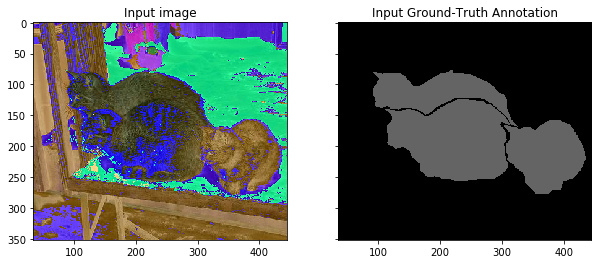

Train step: 0 	Traing Loss: 4.62709 	mIOU: 0.0015119


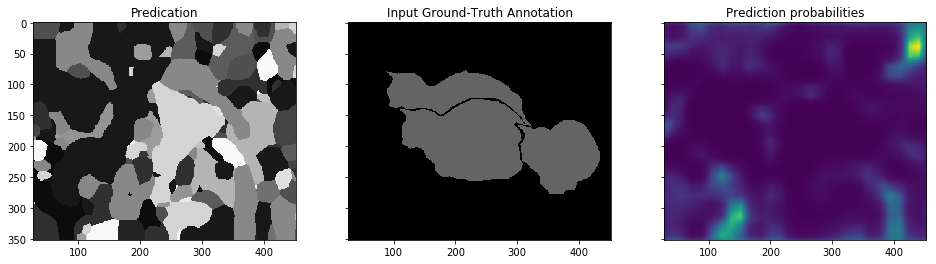

Train step: 1 	Traing Loss: 2.06118 	mIOU: 0.0167322


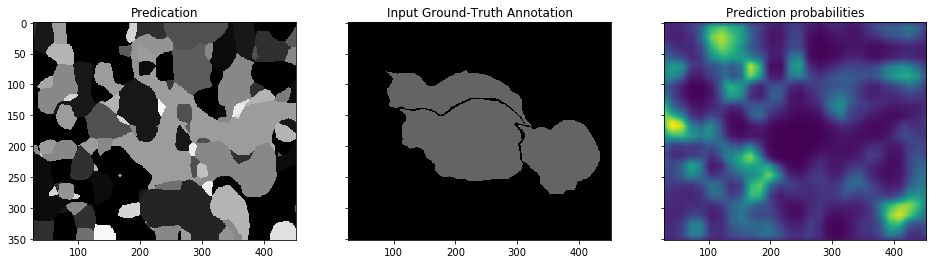

Train step: 2 	Traing Loss: 0.982251 	mIOU: 0.0310642


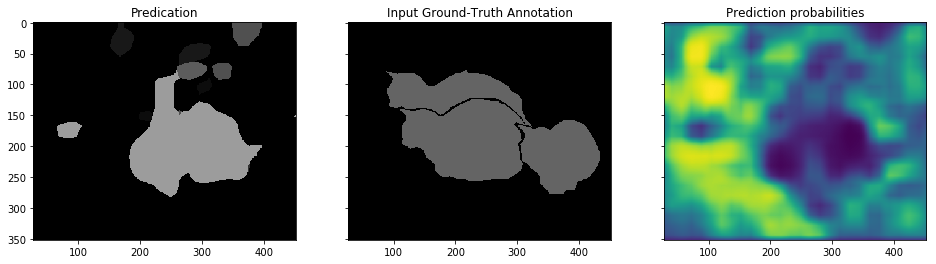

Train step: 3 	Traing Loss: 0.593754 	mIOU: 0.0375439


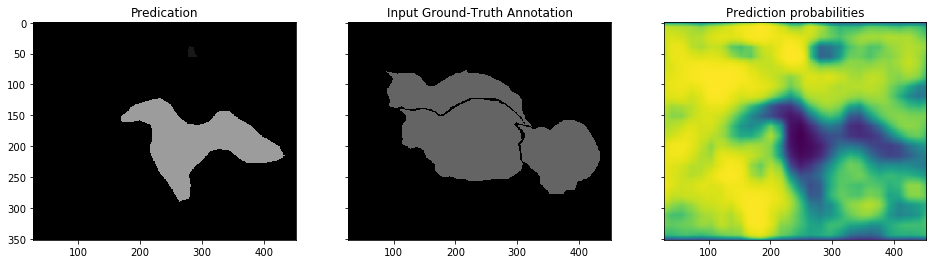

Train step: 4 	Traing Loss: 0.365706 	mIOU: 0.0427949


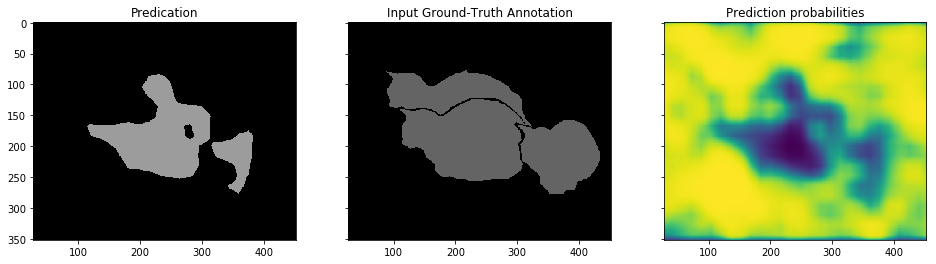

Train step: 5 	Traing Loss: 0.228256 	mIOU: 0.0483936


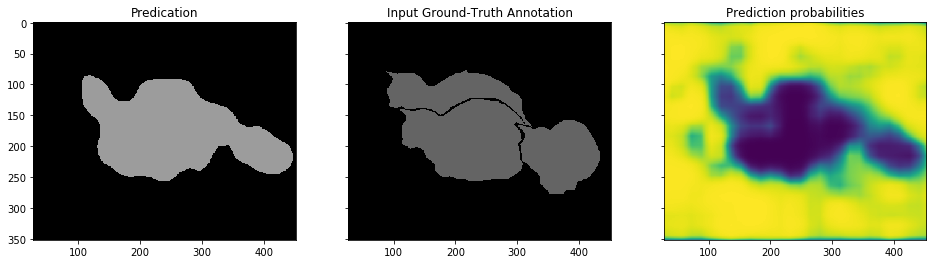

Train step: 6 	Traing Loss: 0.214794 	mIOU: 0.0525115


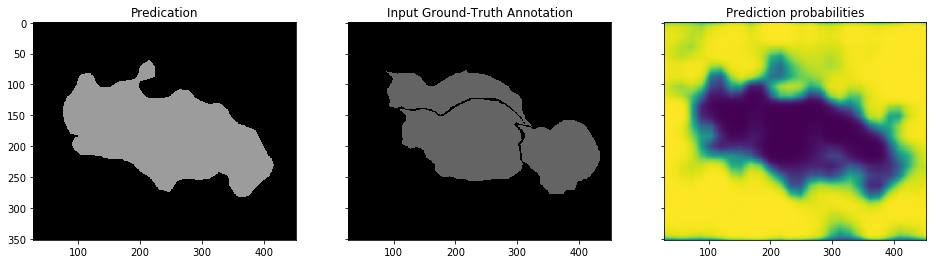

Train step: 7 	Traing Loss: 0.195452 	mIOU: 0.0558813


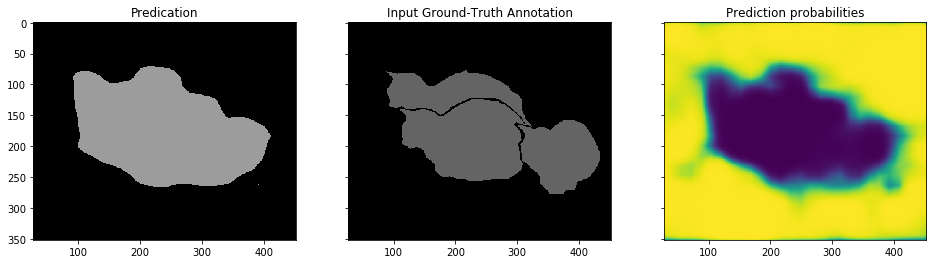

Train step: 8 	Traing Loss: 0.180203 	mIOU: 0.0587593


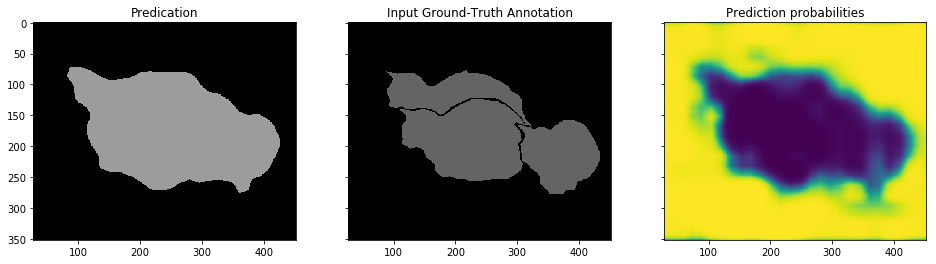

Train step: 9 	Traing Loss: 0.141079 	mIOU: 0.0610001


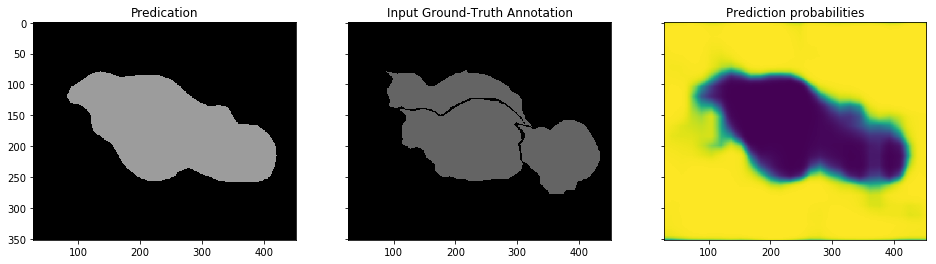

Train step: 10 	Traing Loss: 0.11655 	mIOU: 0.0630148


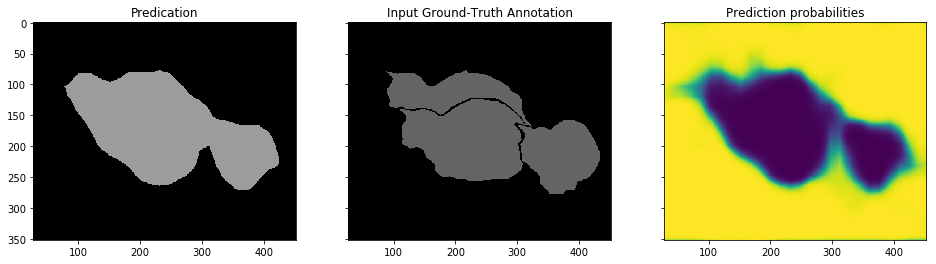

Train step: 11 	Traing Loss: 0.138798 	mIOU: 0.0645596


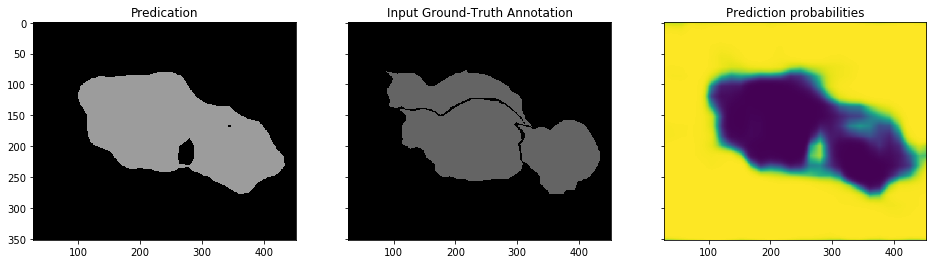

Train step: 12 	Traing Loss: 0.119778 	mIOU: 0.066073


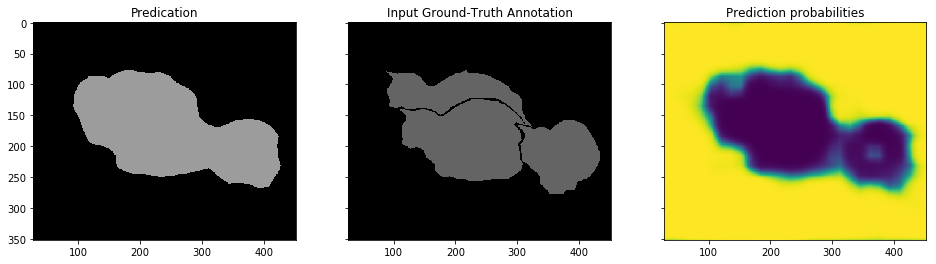

Train step: 13 	Traing Loss: 0.112237 	mIOU: 0.067426


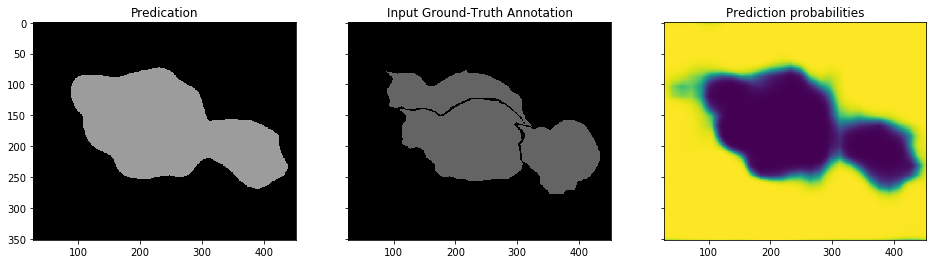

Train step: 14 	Traing Loss: 0.107805 	mIOU: 0.0686308


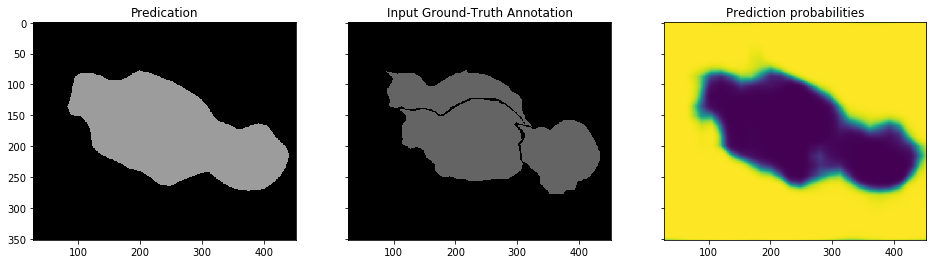

Train step: 15 	Traing Loss: 0.096004 	mIOU: 0.0697039


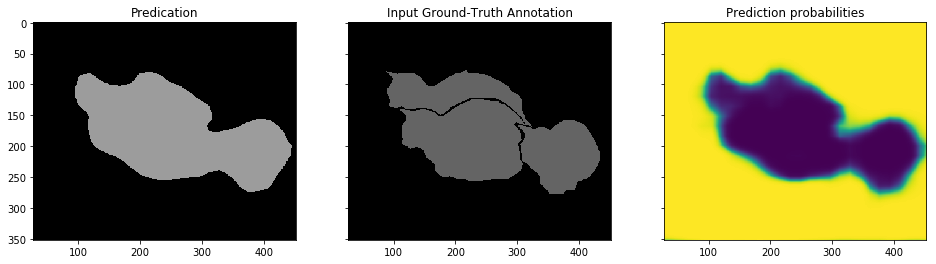

Train step: 16 	Traing Loss: 0.117907 	mIOU: 0.0705641


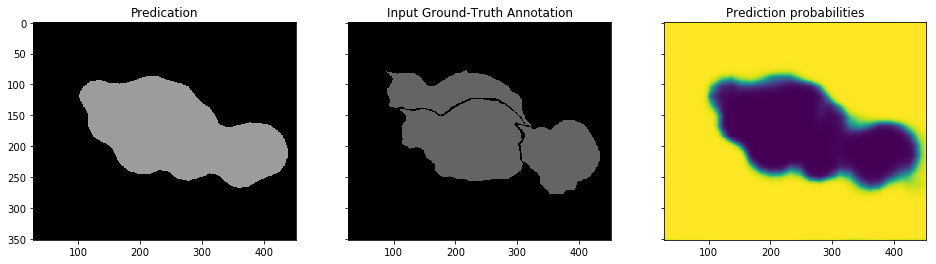

Train step: 17 	Traing Loss: 0.115031 	mIOU: 0.0712615


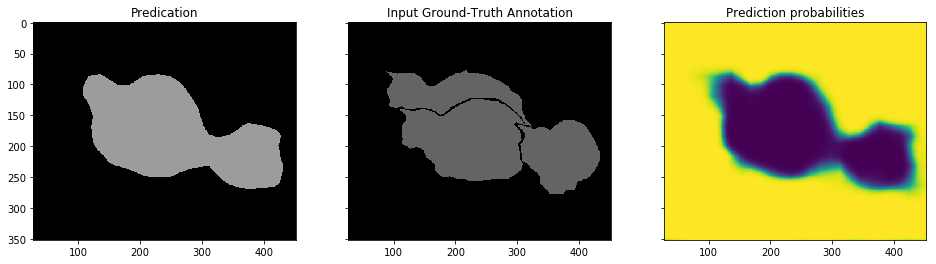

Train step: 18 	Traing Loss: 0.107845 	mIOU: 0.071946


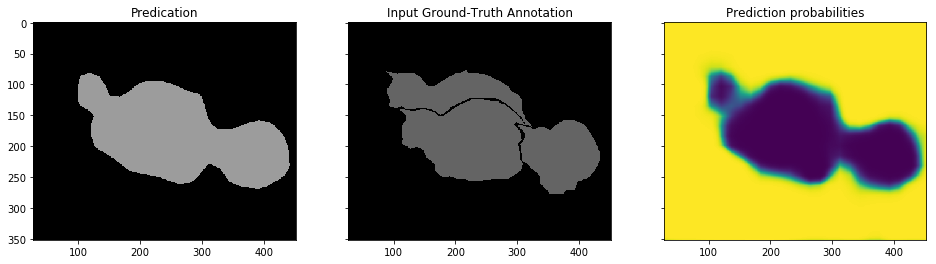

Train step: 19 	Traing Loss: 0.11149 	mIOU: 0.0726197


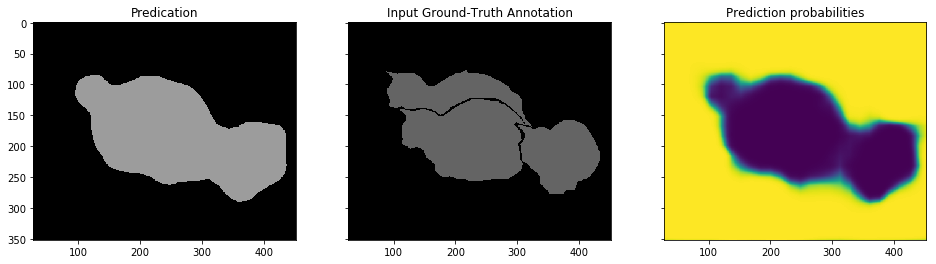

Train step: 20 	Traing Loss: 0.101561 	mIOU: 0.0732478


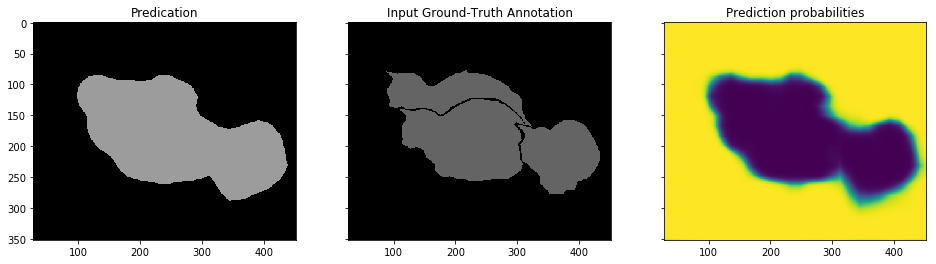

Train step: 21 	Traing Loss: 0.0904917 	mIOU: 0.0738758


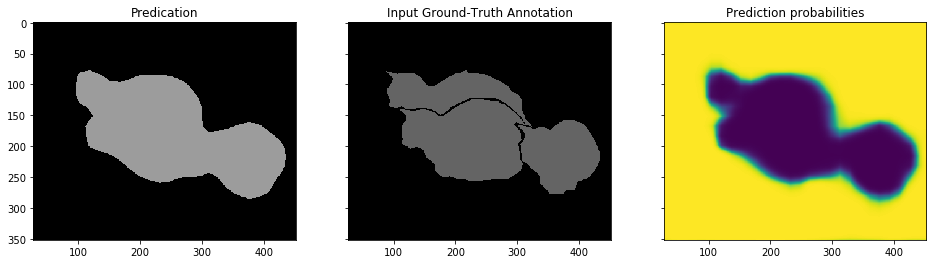

Train step: 22 	Traing Loss: 0.111221 	mIOU: 0.0743859


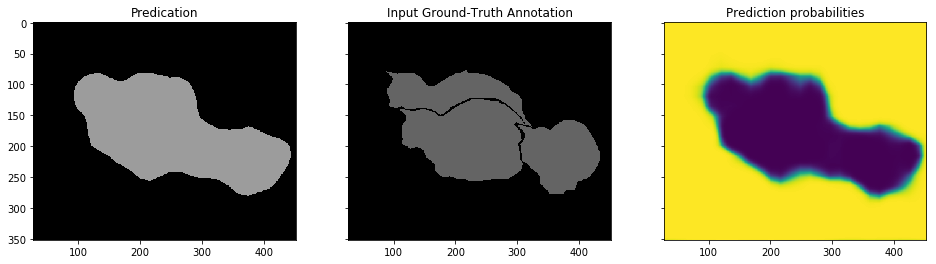

Train step: 23 	Traing Loss: 0.0815312 	mIOU: 0.0749524


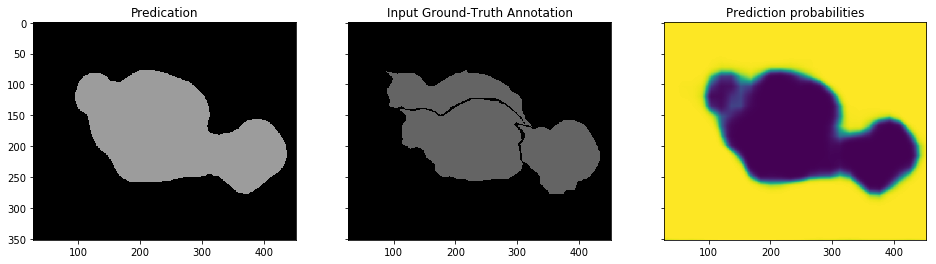

Train step: 24 	Traing Loss: 0.0756602 	mIOU: 0.0754734


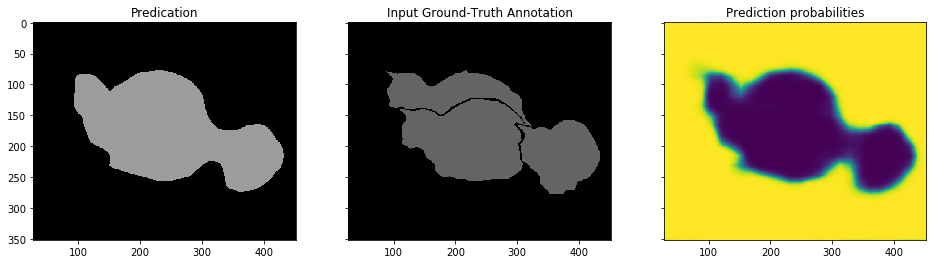

Train step: 25 	Traing Loss: 0.0671682 	mIOU: 0.0759825


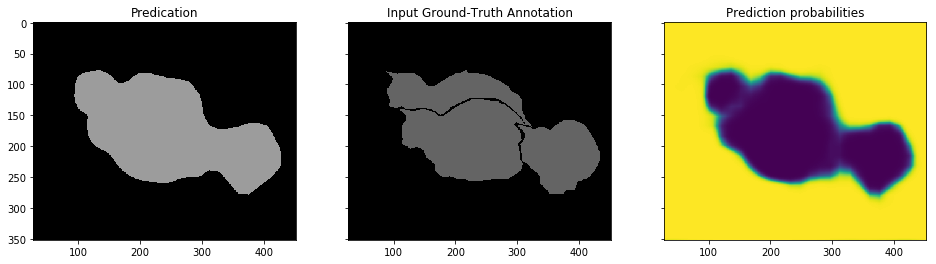

Train step: 26 	Traing Loss: 0.0862589 	mIOU: 0.076423


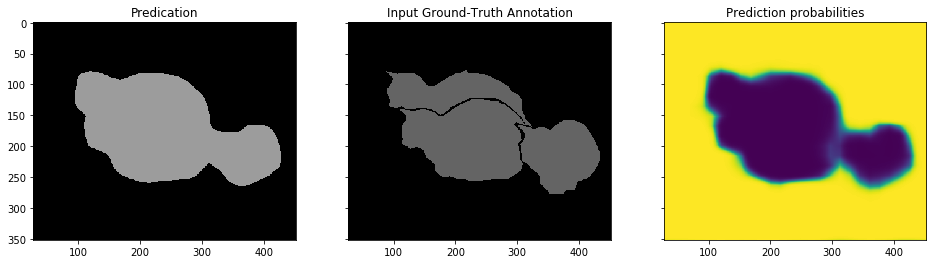

Train step: 27 	Traing Loss: 0.0883926 	mIOU: 0.0768037


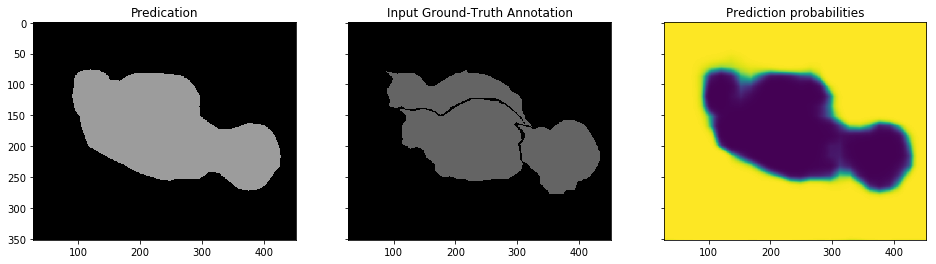

Train step: 28 	Traing Loss: 0.0769739 	mIOU: 0.0771888


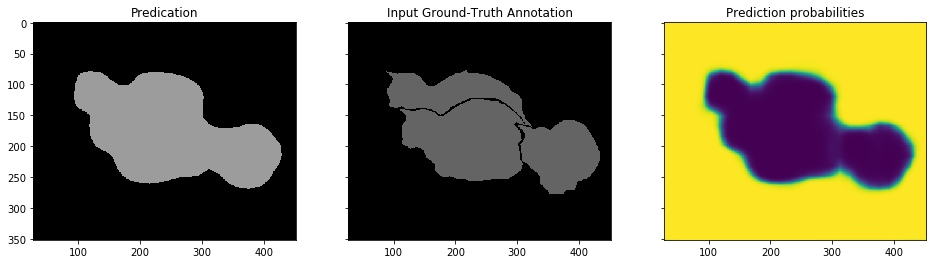

Train step: 29 	Traing Loss: 0.0670093 	mIOU: 0.0775928


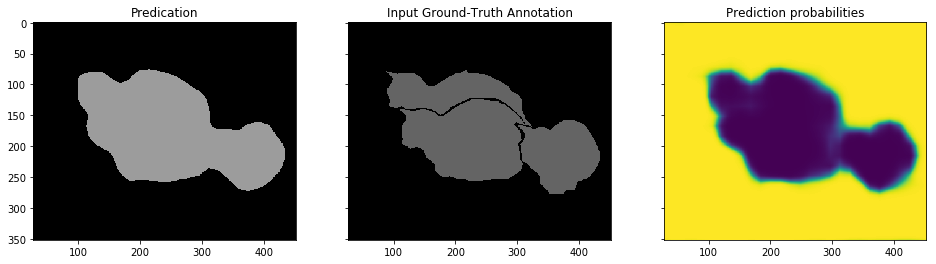

Train step: 30 	Traing Loss: 0.073022 	mIOU: 0.0779471


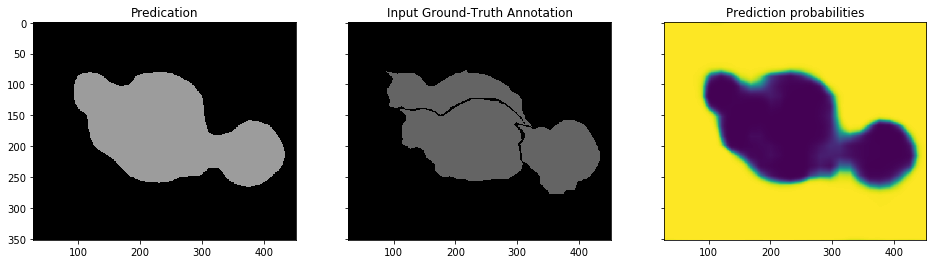

Train step: 31 	Traing Loss: 0.0650558 	mIOU: 0.0783115


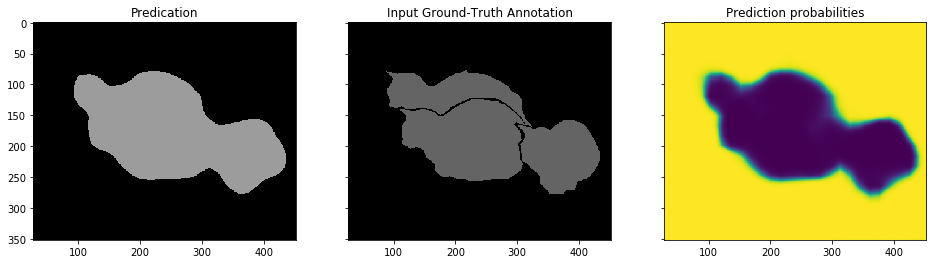

Train step: 32 	Traing Loss: 0.0681022 	mIOU: 0.0786306


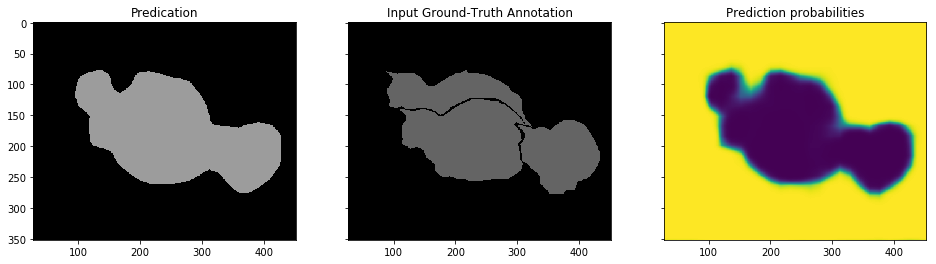

Train step: 33 	Traing Loss: 0.0641621 	mIOU: 0.0789481


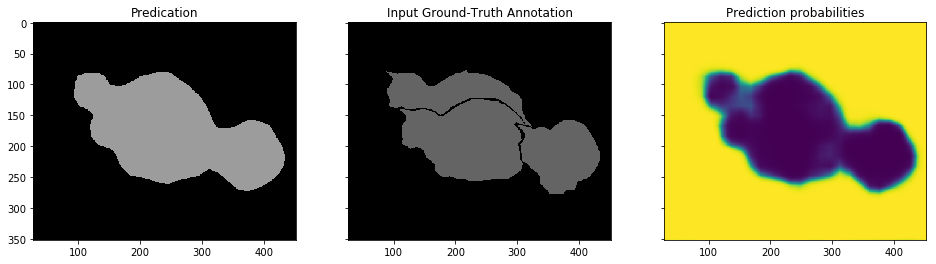

Train step: 34 	Traing Loss: 0.0607182 	mIOU: 0.0792508


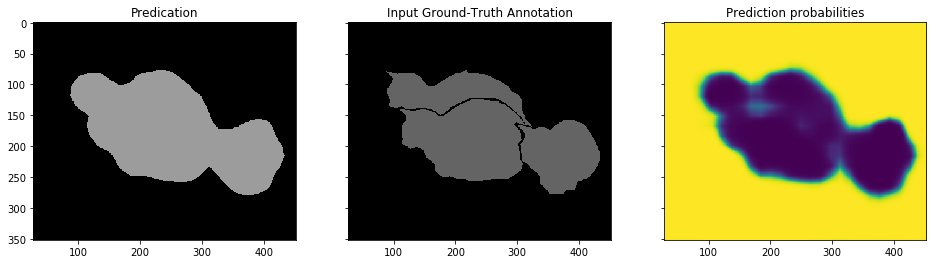

Train step: 35 	Traing Loss: 0.0643485 	mIOU: 0.0795258


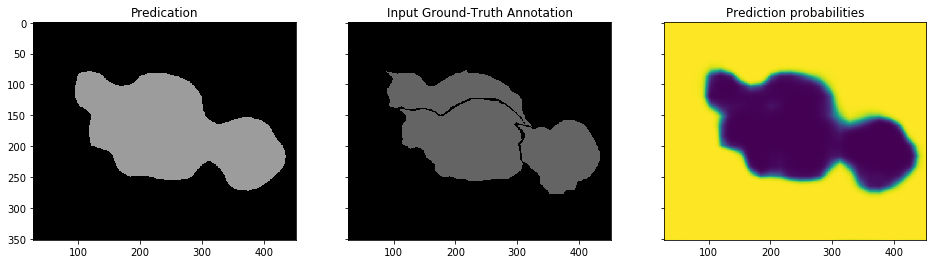

Train step: 36 	Traing Loss: 0.0623081 	mIOU: 0.0797793


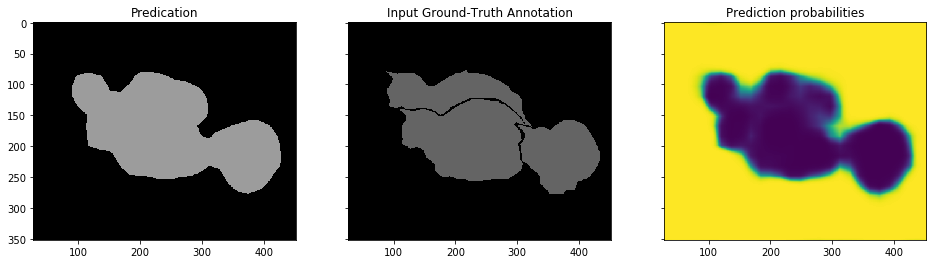

Train step: 37 	Traing Loss: 0.063086 	mIOU: 0.0800203


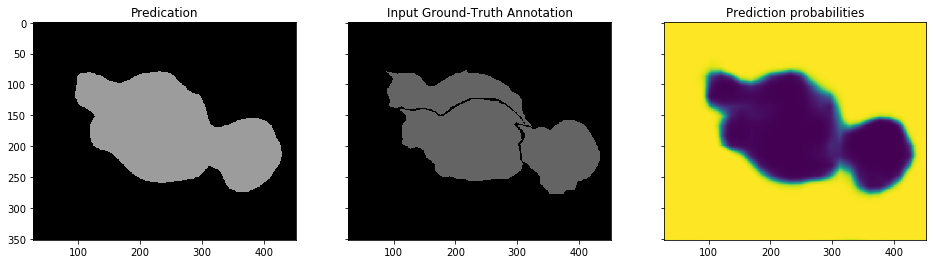

Train step: 38 	Traing Loss: 0.0609832 	mIOU: 0.0802575


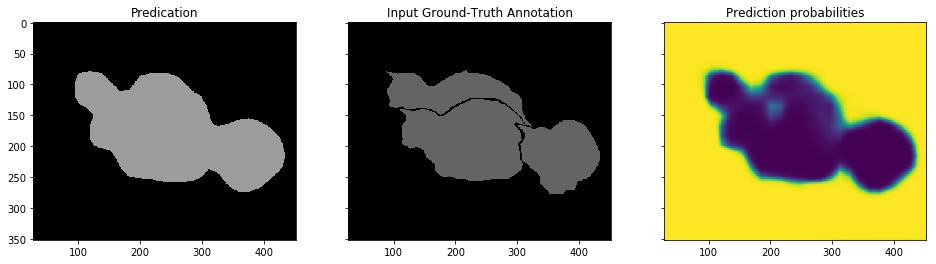

Train step: 39 	Traing Loss: 0.0595506 	mIOU: 0.0804805


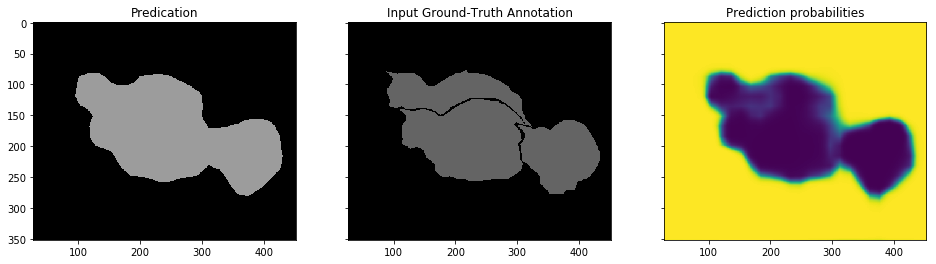

Train step: 40 	Traing Loss: 0.0628649 	mIOU: 0.0806931


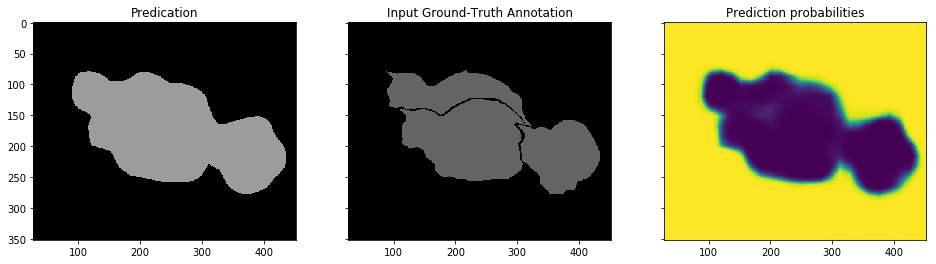

Train step: 41 	Traing Loss: 0.0572169 	mIOU: 0.0809126


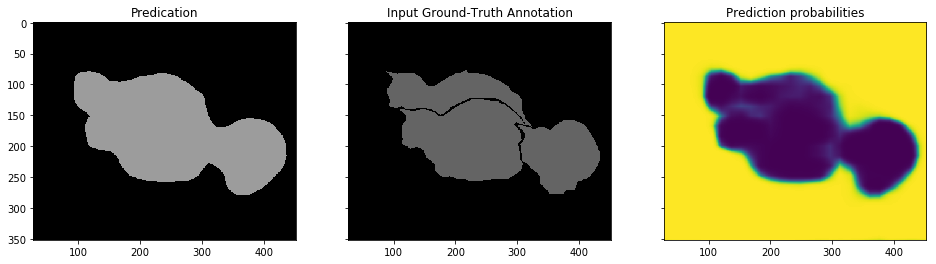

Train step: 42 	Traing Loss: 0.0622067 	mIOU: 0.0811174


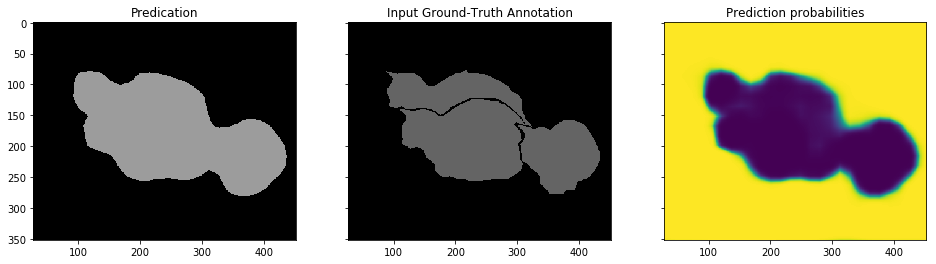

Train step: 43 	Traing Loss: 0.0519297 	mIOU: 0.0813263


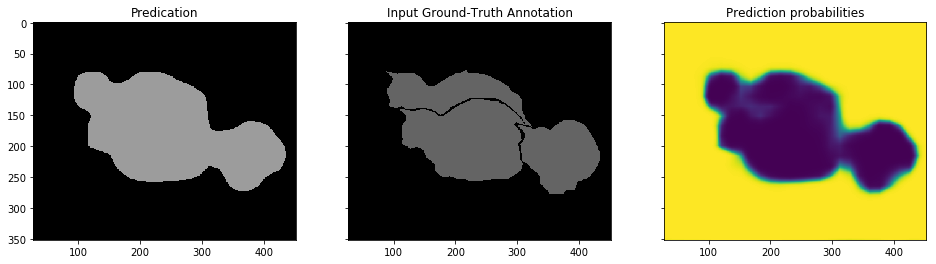

Train step: 44 	Traing Loss: 0.0604002 	mIOU: 0.0814985


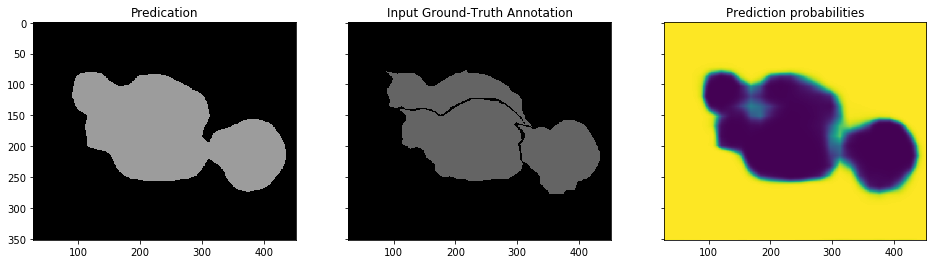

Train step: 45 	Traing Loss: 0.0554809 	mIOU: 0.0816873


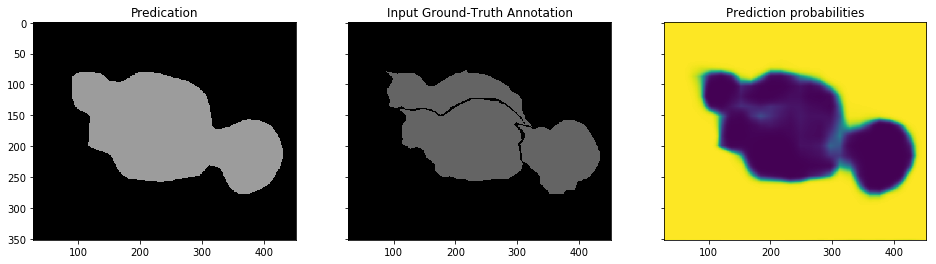

Train step: 46 	Traing Loss: 0.0539107 	mIOU: 0.0818688


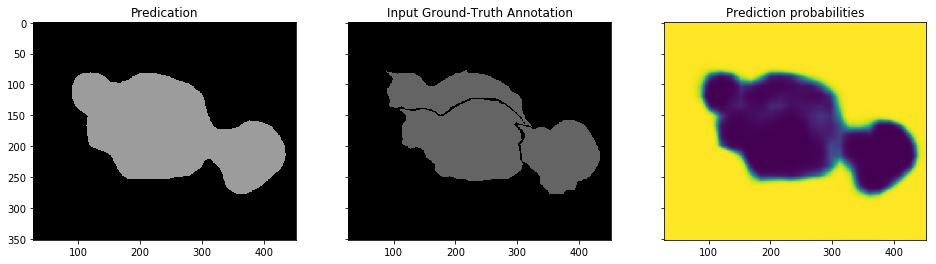

Train step: 47 	Traing Loss: 0.0553537 	mIOU: 0.0820344


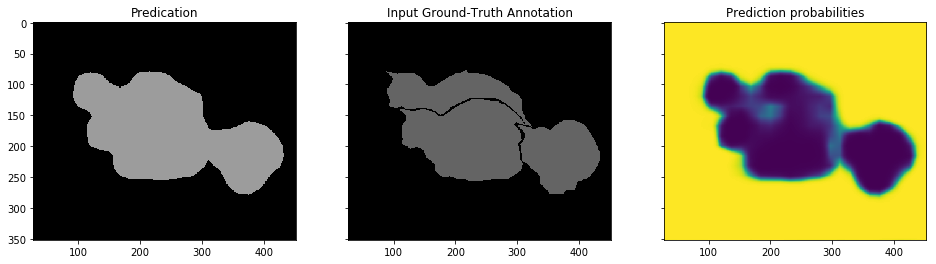

Train step: 48 	Traing Loss: 0.0586598 	mIOU: 0.0821826


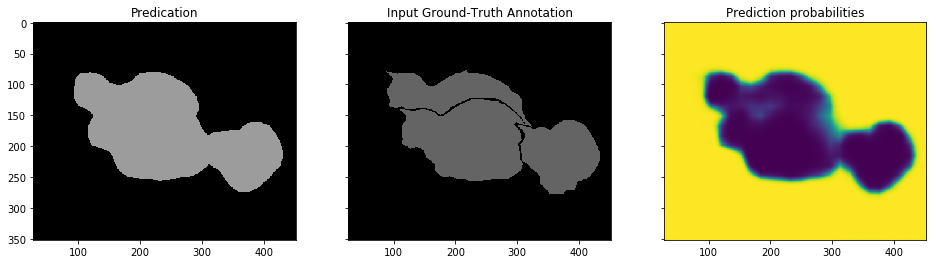

Train step: 49 	Traing Loss: 0.053072 	mIOU: 0.0823382


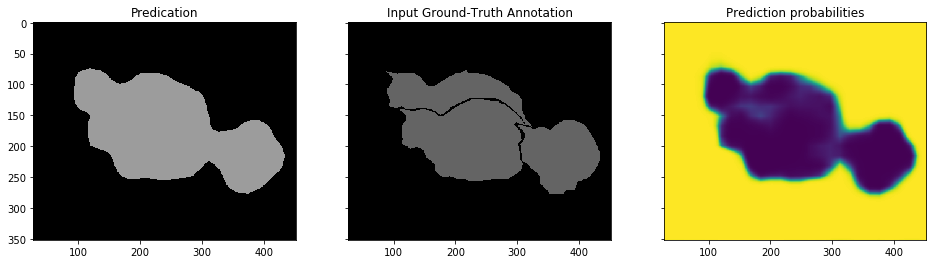

Train step: 50 	Traing Loss: 0.0510332 	mIOU: 0.082501


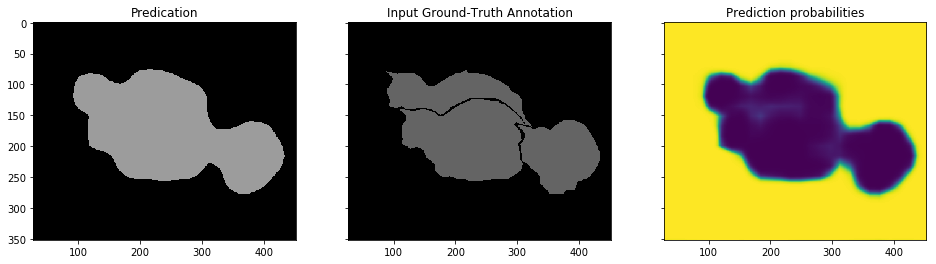

Train step: 51 	Traing Loss: 0.0502857 	mIOU: 0.0826563


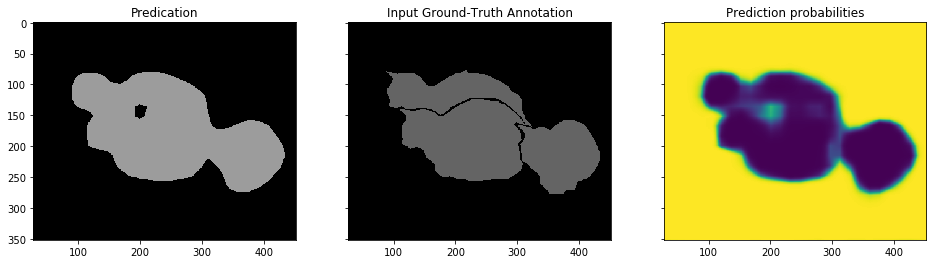

Train step: 52 	Traing Loss: 0.0538016 	mIOU: 0.082798


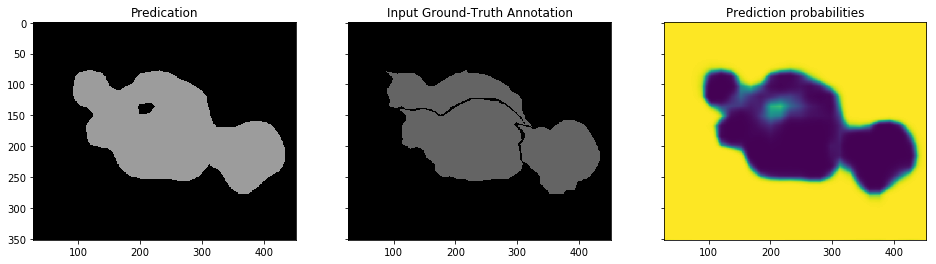

Train step: 53 	Traing Loss: 0.0528222 	mIOU: 0.0829348


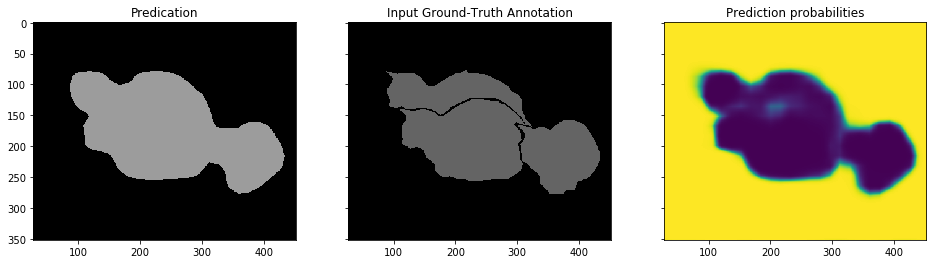

Train step: 54 	Traing Loss: 0.0522278 	mIOU: 0.0830652


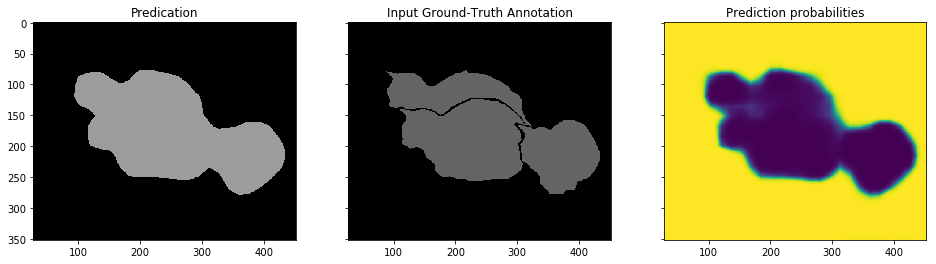

Train step: 55 	Traing Loss: 0.0511778 	mIOU: 0.0832034


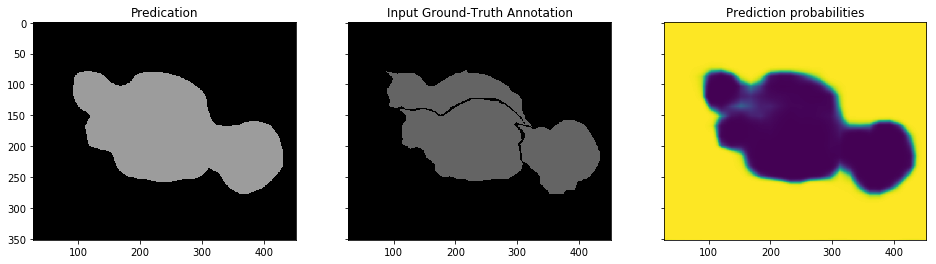

Train step: 56 	Traing Loss: 0.0485486 	mIOU: 0.0833395


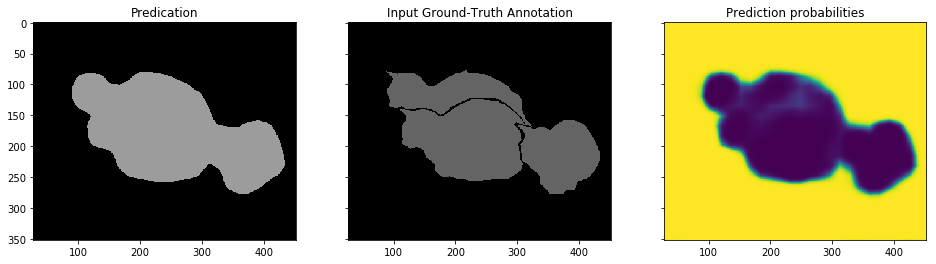

Train step: 57 	Traing Loss: 0.0527589 	mIOU: 0.0834594


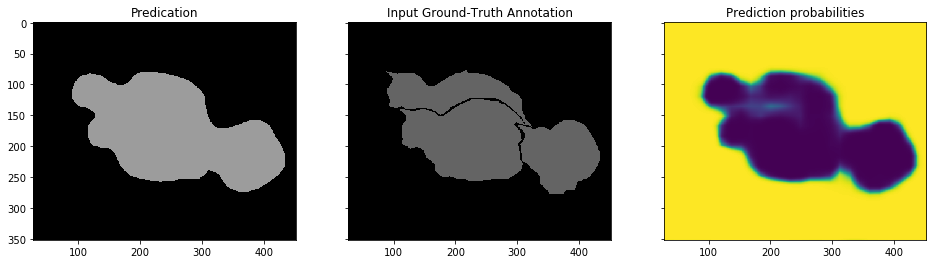

Train step: 58 	Traing Loss: 0.0539882 	mIOU: 0.0835722


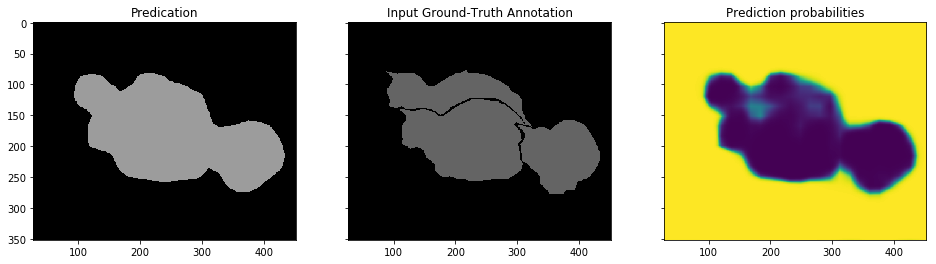

Train step: 59 	Traing Loss: 0.0552597 	mIOU: 0.0836787


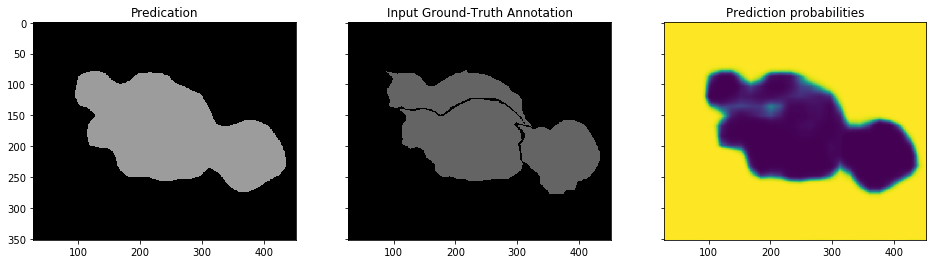

Train step: 60 	Traing Loss: 0.050282 	mIOU: 0.0837891


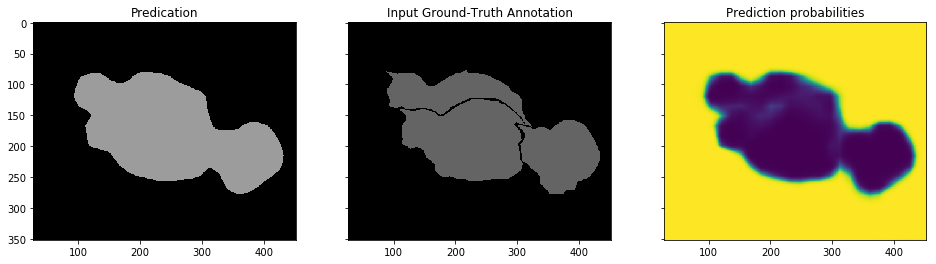

Train step: 61 	Traing Loss: 0.047952 	mIOU: 0.0839029


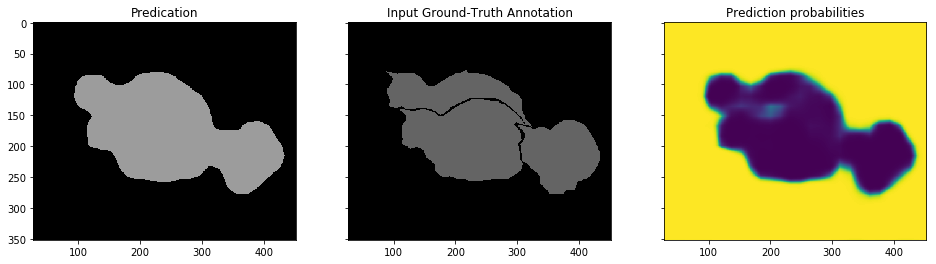

Train step: 62 	Traing Loss: 0.0481452 	mIOU: 0.0840129


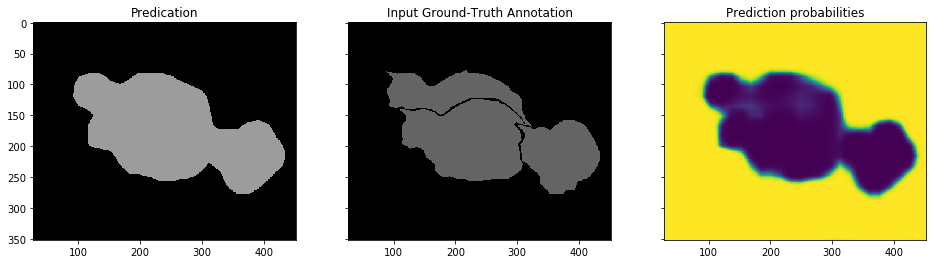

Train step: 63 	Traing Loss: 0.0459663 	mIOU: 0.0841249


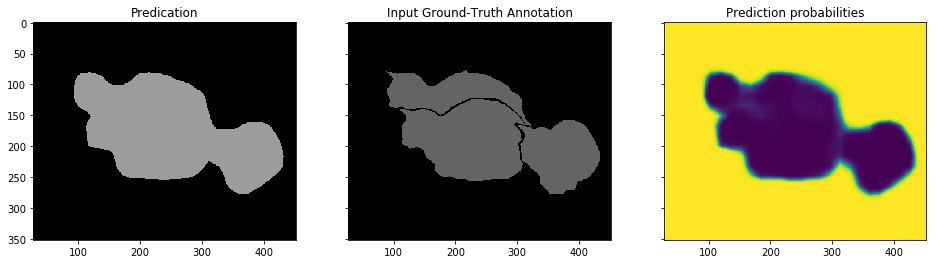

Train step: 64 	Traing Loss: 0.0469895 	mIOU: 0.0842311


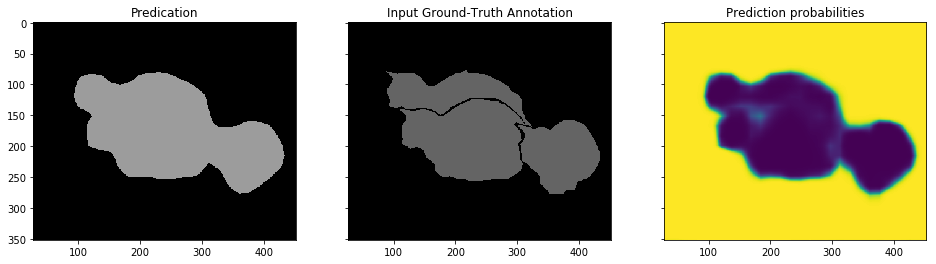

Train step: 65 	Traing Loss: 0.0481496 	mIOU: 0.0843296


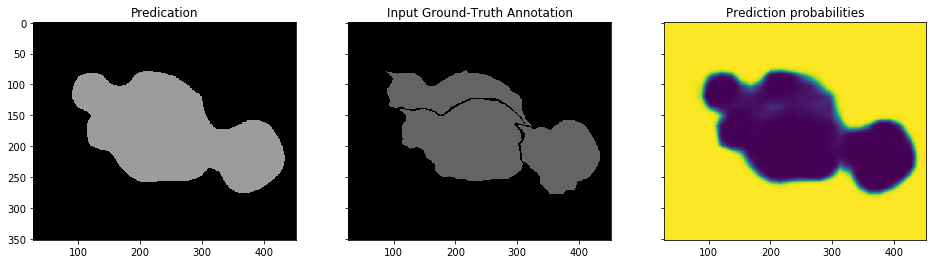

Train step: 66 	Traing Loss: 0.0450941 	mIOU: 0.0844318


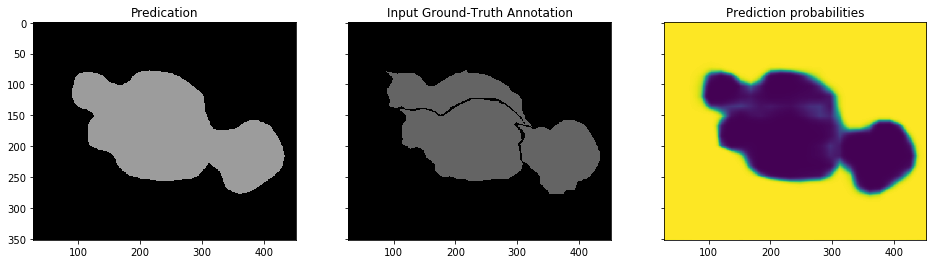

Train step: 67 	Traing Loss: 0.0470906 	mIOU: 0.0845251


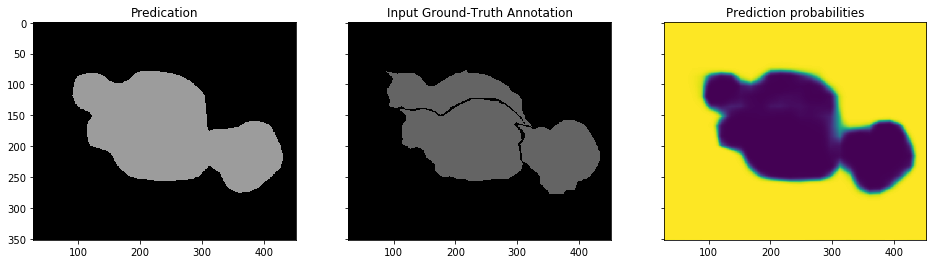

Train step: 68 	Traing Loss: 0.0466325 	mIOU: 0.084618


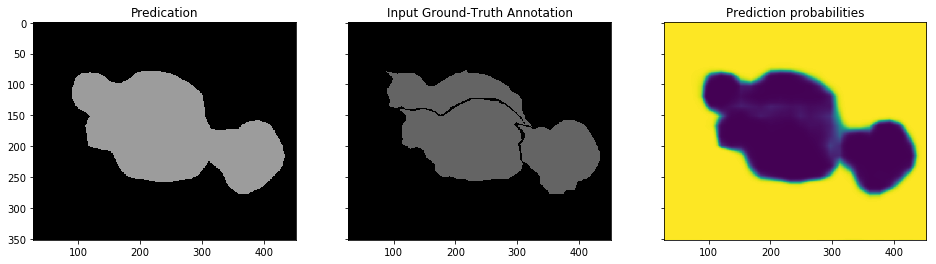

Train step: 69 	Traing Loss: 0.0446915 	mIOU: 0.0847084


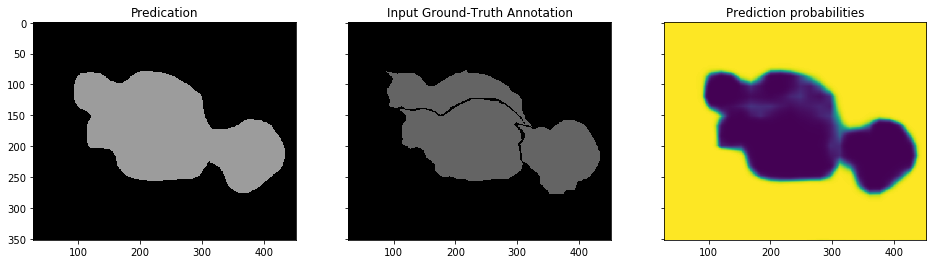

Train step: 70 	Traing Loss: 0.0476804 	mIOU: 0.0847945


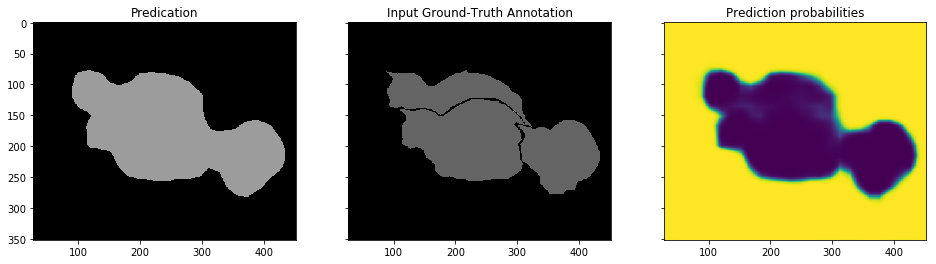

Train step: 71 	Traing Loss: 0.0460886 	mIOU: 0.0848811


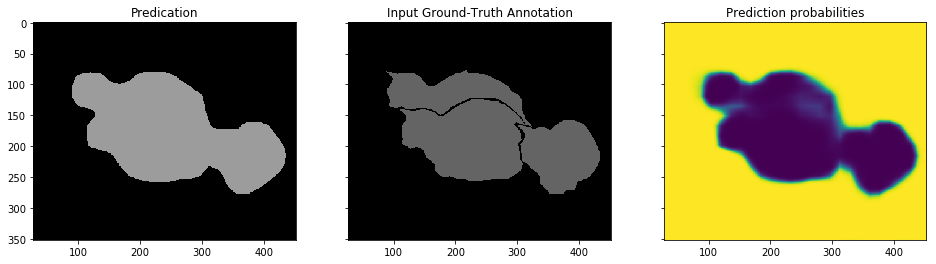

Train step: 72 	Traing Loss: 0.0464192 	mIOU: 0.0849605


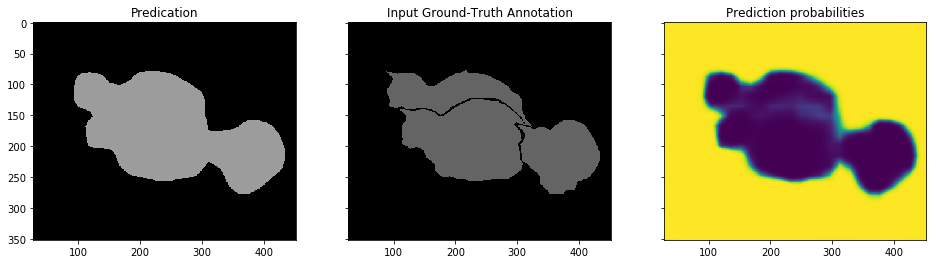

Train step: 73 	Traing Loss: 0.0442355 	mIOU: 0.0850424


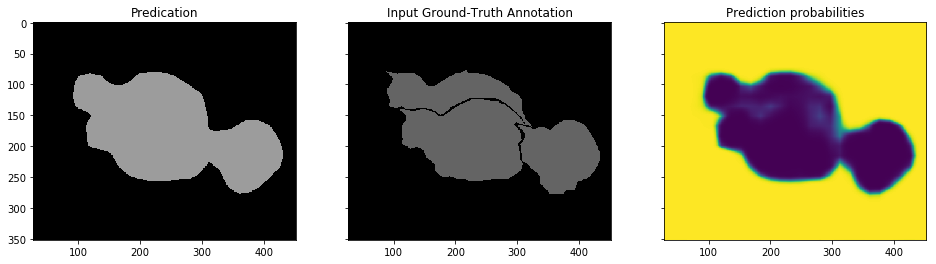

Train step: 74 	Traing Loss: 0.0464144 	mIOU: 0.0851158


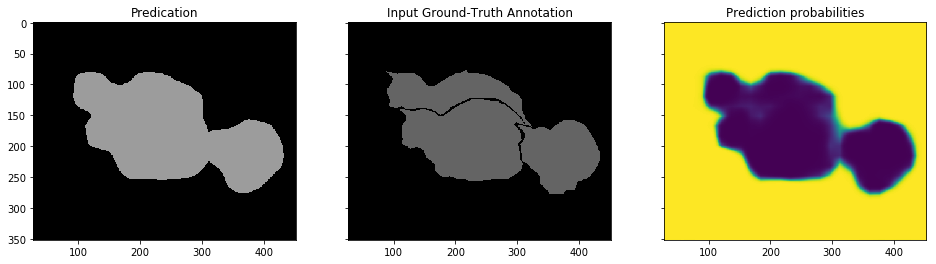

Train step: 75 	Traing Loss: 0.0445699 	mIOU: 0.085191


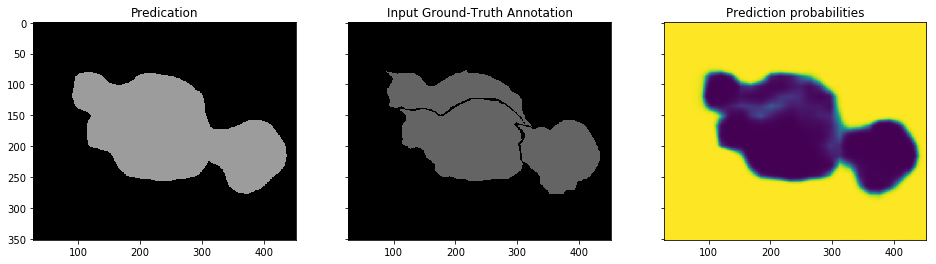

Train step: 76 	Traing Loss: 0.0437031 	mIOU: 0.0852655


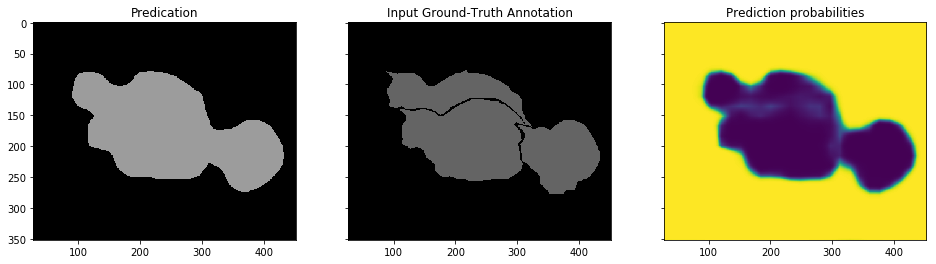

Train step: 77 	Traing Loss: 0.046669 	mIOU: 0.0853332


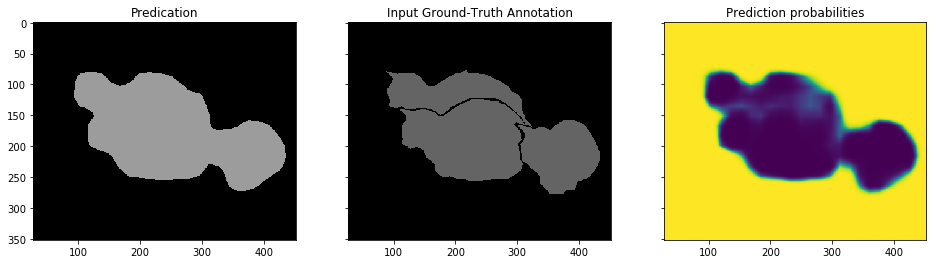

Train step: 78 	Traing Loss: 0.0448208 	mIOU: 0.0854007


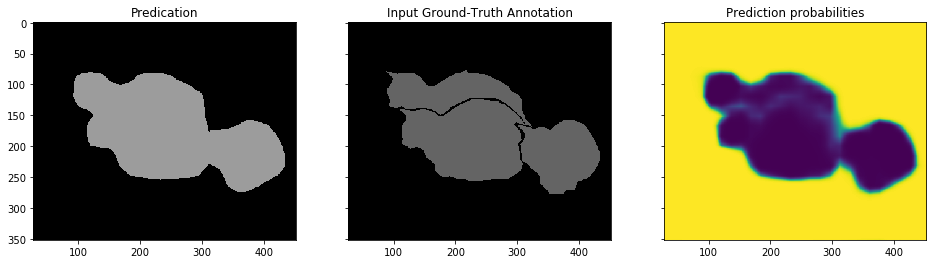

Train step: 79 	Traing Loss: 0.0429344 	mIOU: 0.0854742


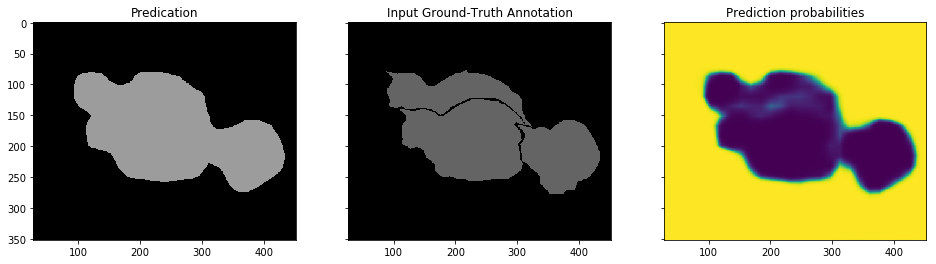

Train step: 80 	Traing Loss: 0.0440558 	mIOU: 0.0855431


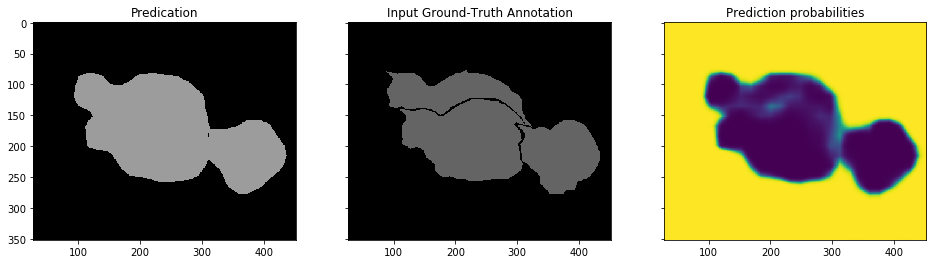

Train step: 81 	Traing Loss: 0.0445668 	mIOU: 0.0856138


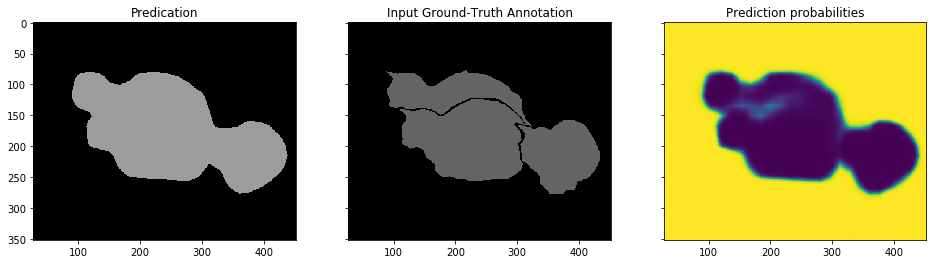

Train step: 82 	Traing Loss: 0.0458744 	mIOU: 0.0856798


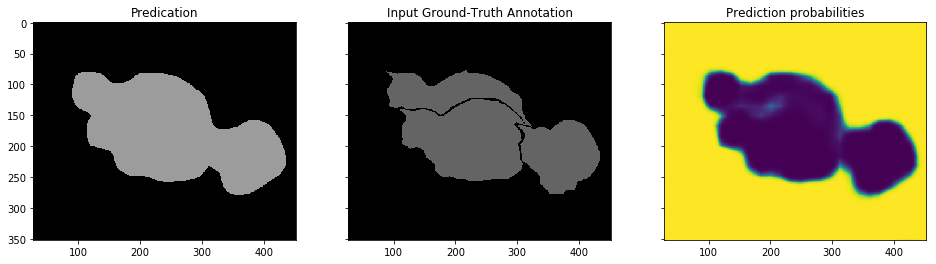

Train step: 83 	Traing Loss: 0.0448848 	mIOU: 0.0857458


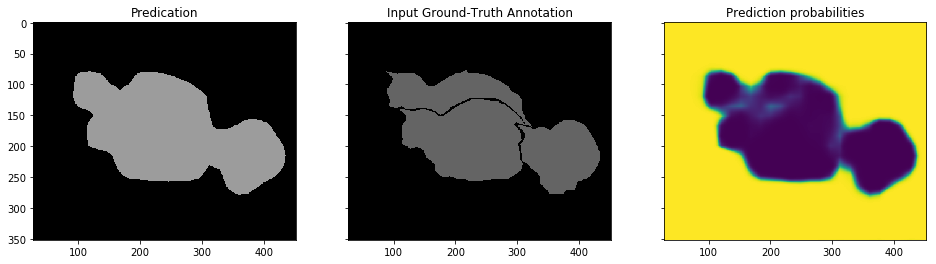

Train step: 84 	Traing Loss: 0.0460652 	mIOU: 0.085805


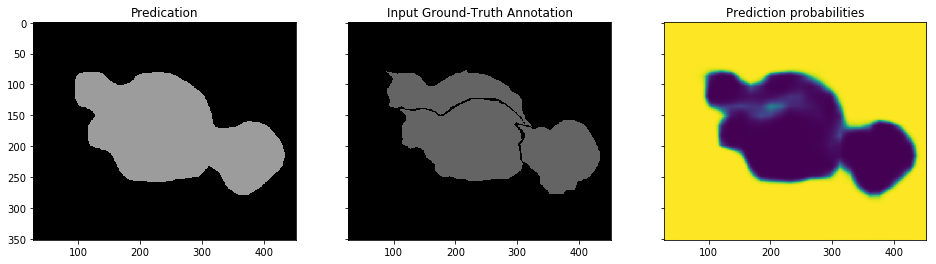

Train step: 85 	Traing Loss: 0.0434666 	mIOU: 0.0858717


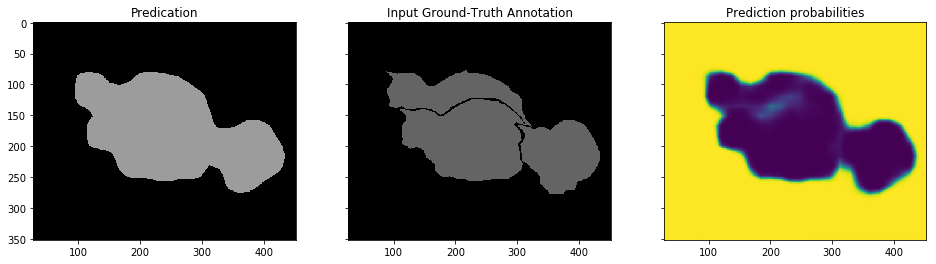

Train step: 86 	Traing Loss: 0.0421346 	mIOU: 0.0859357


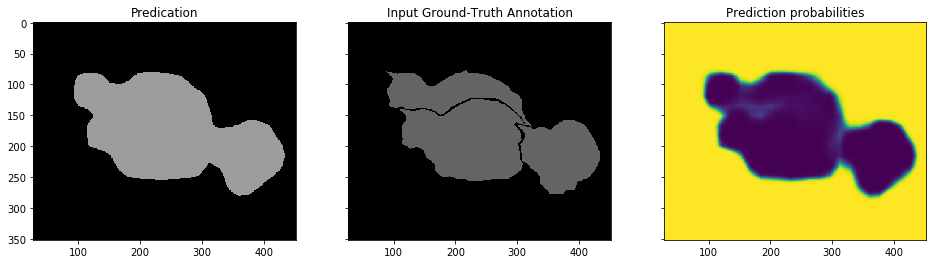

Train step: 87 	Traing Loss: 0.0414012 	mIOU: 0.085997


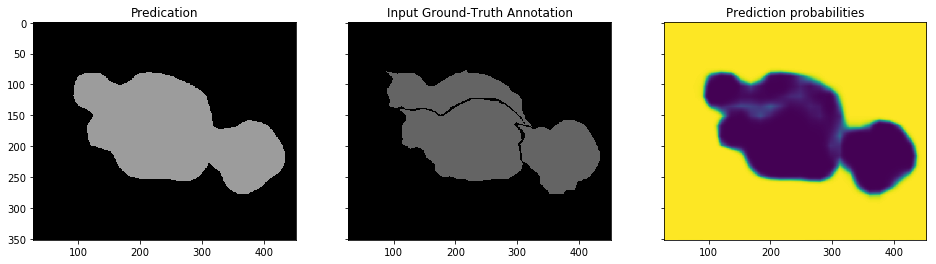

Train step: 88 	Traing Loss: 0.0416547 	mIOU: 0.0860569


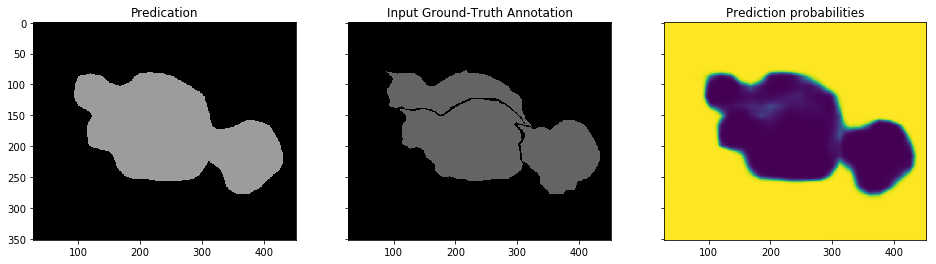

Train step: 89 	Traing Loss: 0.0419041 	mIOU: 0.0861144


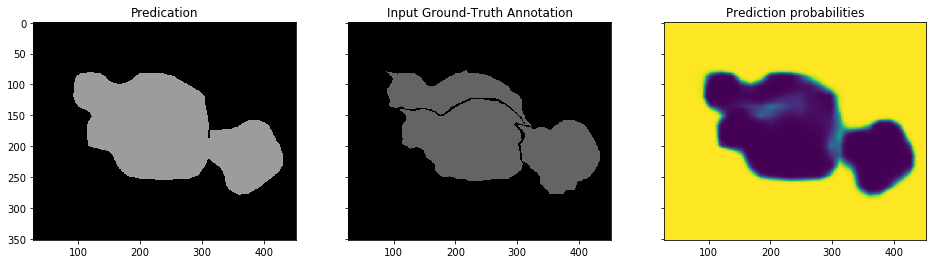

Train step: 90 	Traing Loss: 0.0430389 	mIOU: 0.0861672


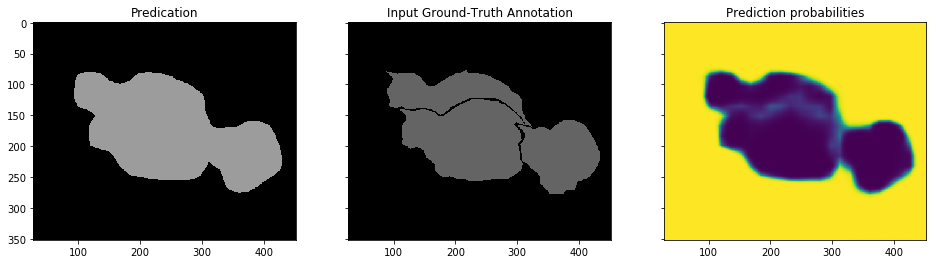

Train step: 91 	Traing Loss: 0.0393274 	mIOU: 0.0862271


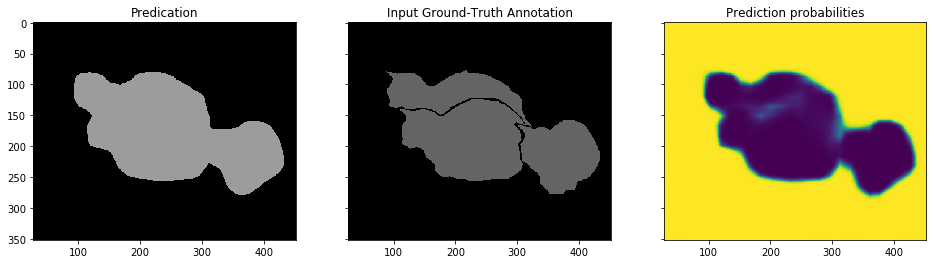

Train step: 92 	Traing Loss: 0.0418219 	mIOU: 0.0862825


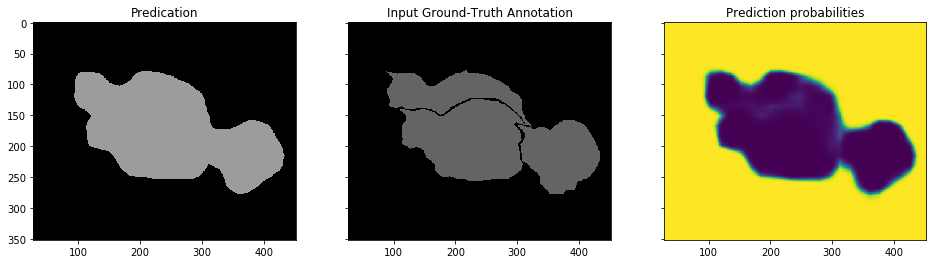

Train step: 93 	Traing Loss: 0.040133 	mIOU: 0.0863367


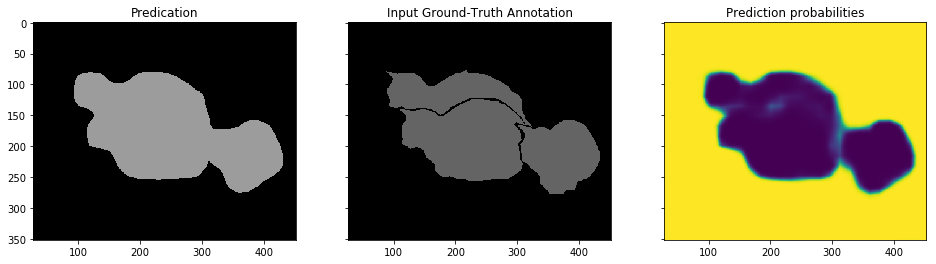

Train step: 94 	Traing Loss: 0.0407785 	mIOU: 0.0863929


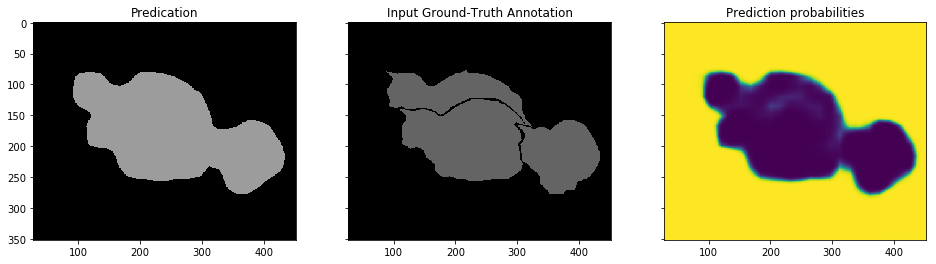

Train step: 95 	Traing Loss: 0.042964 	mIOU: 0.0864432


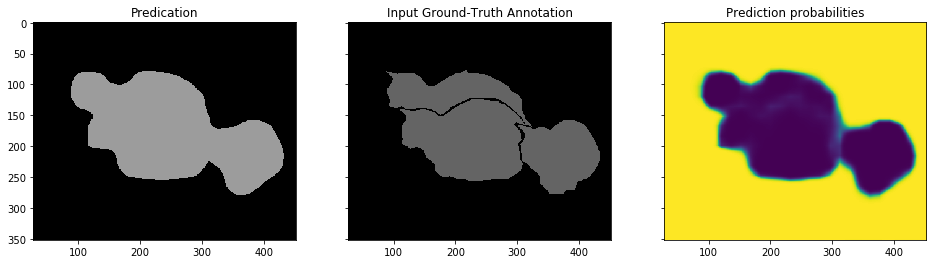

Train step: 96 	Traing Loss: 0.0410662 	mIOU: 0.0864935


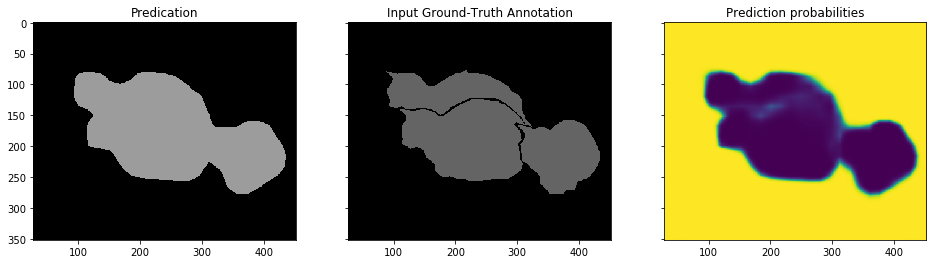

Train step: 97 	Traing Loss: 0.0408754 	mIOU: 0.0865433


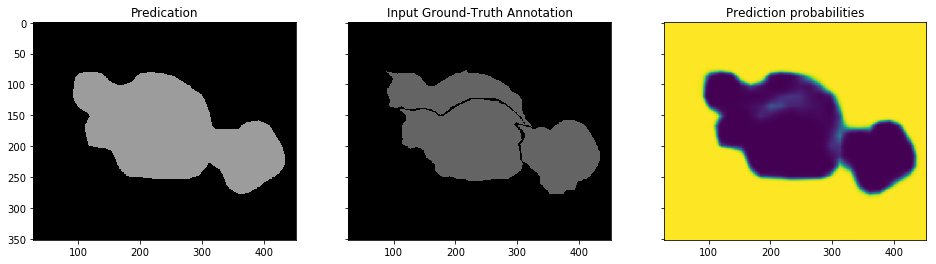

Train step: 98 	Traing Loss: 0.0414185 	mIOU: 0.0865919


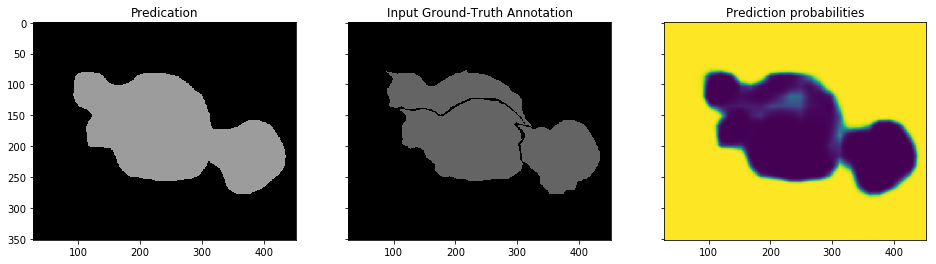

Train step: 99 	Traing Loss: 0.0412234 	mIOU: 0.0866399


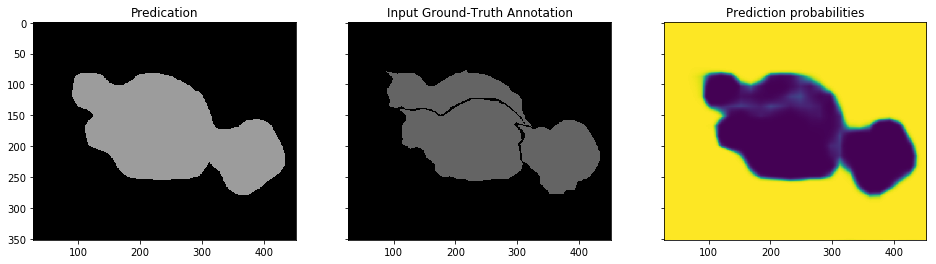

In [17]:
# Initializer for new fc8 weights -- for two classes.
vgg_fc8_weights_initializer = tf.variables_initializer(vgg_fc8_weights)

# Initializer for adam variables
optimization_variables_initializer = tf.variables_initializer(adam_optimizer_variables)

model_vars = tf.variables_initializer(model_variables)

# Create a saver.
saver = tf.train.Saver()

with tf.Session() as sess:
    
    # Run the initializers.
    read_vgg_weights_except_fc8_func(sess)
    sess.run(vgg_fc8_weights_initializer)
    sess.run(optimization_variables_initializer)
    sess.run(tf.local_variables_initializer())
    sess.run(model_vars)
    
    train_image, train_annotation = sess.run([image_tensor, annotation_tensor],
                                              feed_dict={is_training_placeholder: False})
    
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    f.set_figheight(4)
    f.set_figwidth(10)
    ax1.imshow(train_image[0])
    ax1.set_title('Input image')
    probability_graph = ax2.imshow(np.dstack((train_annotation,)*3)*100)
    ax2.set_title('Input Ground-Truth Annotation')
    plt.show()
    
    for step in range(100):

        _, train_loss, pred_np, probabilities_np, tmp = sess.run([train_step, cross_entropy_sum, pred, probabilities, update_op],
                                        feed_dict={is_training_placeholder: True})
        miou_np = sess.run(miou)
        
        pred_annotation = np.expand_dims(pred_np[0], axis=2).astype(float)
        print("Train step:", step, "\tTraing Loss:", train_loss, "\tmIOU:", miou_np)

        cmap = plt.get_cmap('bwr')
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
        f.set_figheight(4)
        f.set_figwidth(16)

        ax1.imshow(np.dstack((pred_annotation,)*3)*100)
        ax1.set_title('Predication')
        probability_graph = ax2.imshow(np.dstack((train_annotation,)*3)*100)
        ax2.set_title('Input Ground-Truth Annotation')
        probability_graph = ax3.imshow(probabilities_np.squeeze()[:, :, 0])
        ax3.set_title('Prediction probabilities')
        plt.show()

    sess.close()

    summary_string_writer.close()